<a href="https://colab.research.google.com/github/armandoordonez/deeplearning/blob/main/Pizza_Not_pizza_Hiperparameter_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Datos https://www.kaggle.com/code/rasikagurav/pizza-or-not-pizza


import keras
import cv2
import pathlib
import random
import glob
import os
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Overfitting and underfitting with images dataset

Based on the code of the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

Load data from google drive

# Fighting overfitting

## Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the
validation loss.

Let's try this on our movie review classification network. Our original network was as such:

In [ ]:
path = '/content/drive/MyDrive/pizza_not_pizza (1)'
data_dir=pathlib.Path(path)
image=glob.glob("/content/drive/MyDrive/pizza_not_pizza (1)/*/*.jpg")
image=pd.Series(image)
print("No of images :",len(image))
numero_imagenes = len(image)

No of images : 1966


# Setting train and test data

In [ ]:
# Se importa la clase ImageDataGenerator de Keras para la generación de datos de imágenes para el entrenamiento.
# Se especifica que se debe reescalar los valores de píxeles de las imágenes dividiéndolos por 255 para normalizarlos.
# Se divide el conjunto de datos en un 90% para entrenamiento y un 10% para validación.
train_data = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Se crea un generador de datos de entrenamiento utilizando el método flow_from_directory de train_data.
# Se especifica el directorio que contiene las imágenes.
# Se indica que se utilizará un 80% de los datos para entrenamiento (subset='training').
# Se establece el tamaño al que se redimensionarán las imágenes (224x224 píxeles).
# Se establece el tamaño del lote (batch_size) en 32 imágenes.
train_ds = train_data.flow_from_directory(
    path,
    subset='training',
    target_size=(224, 224),
    batch_size=32
)

# Se crea un generador de datos de validación utilizando el método flow_from_directory de train_data.
# Se especifica el directorio que contiene las imágenes.
# Se indica que se utilizará un 20% de los datos para validación (subset='validation').
# Se establece el tamaño al que se redimensionarán las imágenes (224x224 píxeles).
# Se establece el tamaño del lote (batch_size) en 32 imágenes.
test_ds = train_data.flow_from_directory(
    path,
    subset='validation',
    target_size=(224, 224),
    batch_size=32
)

Found 1770 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [ ]:
from keras import models
from keras.layers import Dense , Flatten, GlobalAveragePooling2D
from keras import layers
from keras import optimizers
from keras.applications import MobileNet

#Optimizer
optimizer = optimizers.legacy.SGD(learning_rate=0.001,momentum=0.09)

#Arquitectura
mobilenet=MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

for layers in mobilenet.layers:
    layers.trainable=False


17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
original_model = models.Sequential()
original_model.add(mobilenet)
original_model.add(GlobalAveragePooling2D())
original_model.add(Flatten(input_shape=(224,224,3)))
original_model.add(Dense(16, activation='relu',input_shape=(224,224,3)))
original_model.add(Dense(16, activation='relu'))
original_model.add(Dense(2, activation='softmax'))
original_model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

In [ ]:
smaller_model = models.Sequential()
smaller_model.add(mobilenet)
smaller_model.add(GlobalAveragePooling2D())
smaller_model.add(Flatten(input_shape=(224,224,3)))
smaller_model.add(Dense(4, activation='relu',input_shape=(224,224,3)))
smaller_model.add(Dense(4, activation='relu'))
smaller_model.add(Dense(2, activation='softmax'))

smaller_model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['acc'])


Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of
the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

In [ ]:
original_hist = original_model.fit(train_ds,
                                   epochs=10,
                                   validation_data=test_ds)

Epoch 1/10
56/56 [==============================] - 102s 2s/step - loss: 0.6070 - acc: 0.6667 - val_loss: 0.5558 - val_acc: 0.6786
Epoch 2/10
56/56 [==============================] - 102s 2s/step - loss: 0.5086 - acc: 0.7921 - val_loss: 0.4846 - val_acc: 0.7755
Epoch 3/10
56/56 [==============================] - 99s 2s/step - loss: 0.4230 - acc: 0.8418 - val_loss: 0.4098 - val_acc: 0.8418
Epoch 4/10
56/56 [==============================] - 109s 2s/step - loss: 0.3489 - acc: 0.8706 - val_loss: 0.3559 - val_acc: 0.8776
Epoch 5/10
56/56 [==============================] - 98s 2s/step - loss: 0.3006 - acc: 0.8842 - val_loss: 0.3193 - val_acc: 0.8929
Epoch 6/10
56/56 [==============================] - 111s 2s/step - loss: 0.2687 - acc: 0.8944 - val_loss: 0.2949 - val_acc: 0.8980
Epoch 7/10
56/56 [==============================] - 109s 2s/step - loss: 0.2460 - acc: 0.9056 - val_loss: 0.2798 - val_acc: 0.9031
Epoch 8/10
56/56 [==============================] - 109s 2s/step - loss: 0.2294 - acc

In [ ]:
smaller_model_hist = smaller_model.fit(train_ds,
                                   epochs=10,
                                   validation_data=test_ds)

Epoch 1/10
56/56 [==============================] - 100s 2s/step - loss: 0.7062 - acc: 0.5158 - val_loss: 0.6999 - val_acc: 0.5459
Epoch 2/10
56/56 [==============================] - 108s 2s/step - loss: 0.6861 - acc: 0.5401 - val_loss: 0.6787 - val_acc: 0.5765
Epoch 3/10
56/56 [==============================] - 98s 2s/step - loss: 0.6679 - acc: 0.5757 - val_loss: 0.6555 - val_acc: 0.6173
Epoch 4/10
56/56 [==============================] - 99s 2s/step - loss: 0.6439 - acc: 0.6119 - val_loss: 0.6221 - val_acc: 0.6122
Epoch 5/10
56/56 [==============================] - 115s 2s/step - loss: 0.6110 - acc: 0.6689 - val_loss: 0.5797 - val_acc: 0.6990
Epoch 6/10
56/56 [==============================] - 100s 2s/step - loss: 0.5796 - acc: 0.7237 - val_loss: 0.5465 - val_acc: 0.7551
Epoch 7/10
56/56 [==============================] - 98s 2s/step - loss: 0.5532 - acc: 0.7672 - val_loss: 0.5195 - val_acc: 0.8112
Epoch 8/10
56/56 [==============================] - 109s 2s/step - loss: 0.5304 - acc:

In [ ]:
epochs = range(1, 11)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

In [ ]:
print("ORIGINAL: ",original_val_loss)
print("SMALLER: ",smaller_model_val_loss)

ORIGINAL:  [0.5558176040649414, 0.48463448882102966, 0.4098283350467682, 0.3558728098869324, 0.31925100088119507, 0.29494237899780273, 0.2798371911048889, 0.26974210143089294, 0.2602381706237793, 0.2502049505710602]
SMALLER:  [0.6999046206474304, 0.6787309646606445, 0.6554997563362122, 0.6220924258232117, 0.5796797275543213, 0.5465444922447205, 0.5195380449295044, 0.4934883117675781, 0.4760952889919281, 0.45930546522140503]


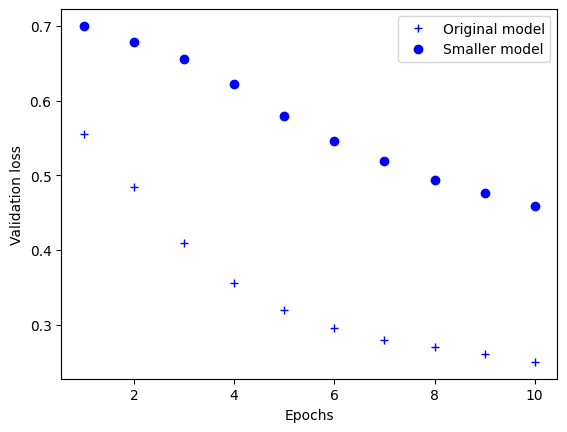

In [ ]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [ ]:
bigger_model = models.Sequential()
bigger_model.add(mobilenet)
bigger_model.add(GlobalAveragePooling2D())
bigger_model.add(Flatten(input_shape=(224,224,3)))
bigger_model.add(Dense(128, activation='relu', input_shape=(224,224,3)))
bigger_model.add(Dense(128, activation='relu'))
bigger_model.add(Dense(2, activation='softmax'))

bigger_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['acc'])

In [ ]:
bigger_model_hist = bigger_model.fit(train_ds,
                                   epochs=10,
                                   validation_data=test_ds)

Epoch 1/10
56/56 [==============================] - 97s 2s/step - loss: 0.7730 - acc: 0.5412 - val_loss: 0.5916 - val_acc: 0.7143
Epoch 2/10
56/56 [==============================] - 93s 2s/step - loss: 0.5381 - acc: 0.7554 - val_loss: 0.4645 - val_acc: 0.8367
Epoch 3/10
56/56 [==============================] - 107s 2s/step - loss: 0.4330 - acc: 0.8350 - val_loss: 0.3903 - val_acc: 0.8622
Epoch 4/10
56/56 [==============================] - 96s 2s/step - loss: 0.3685 - acc: 0.8689 - val_loss: 0.3405 - val_acc: 0.8980
Epoch 5/10
56/56 [==============================] - 101s 2s/step - loss: 0.3229 - acc: 0.8864 - val_loss: 0.3065 - val_acc: 0.9082
Epoch 6/10
56/56 [==============================] - 96s 2s/step - loss: 0.2917 - acc: 0.8966 - val_loss: 0.2833 - val_acc: 0.9082
Epoch 7/10
56/56 [==============================] - 96s 2s/step - loss: 0.2679 - acc: 0.9017 - val_loss: 0.2652 - val_acc: 0.9184
Epoch 8/10
56/56 [==============================] - 98s 2s/step - loss: 0.2499 - acc: 0.

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the
crosses are the initial network.

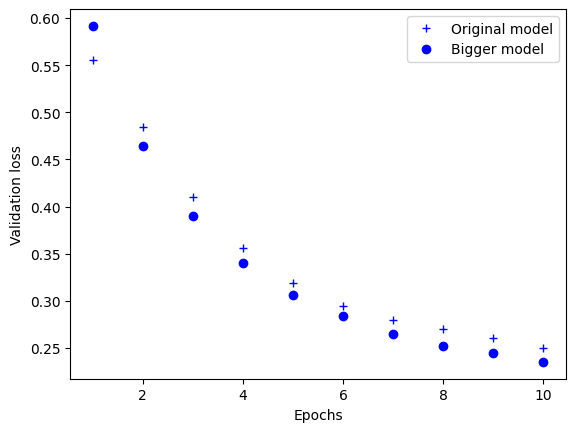

In [ ]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also
more noisy.

Meanwhile, here are the training losses for our two networks:

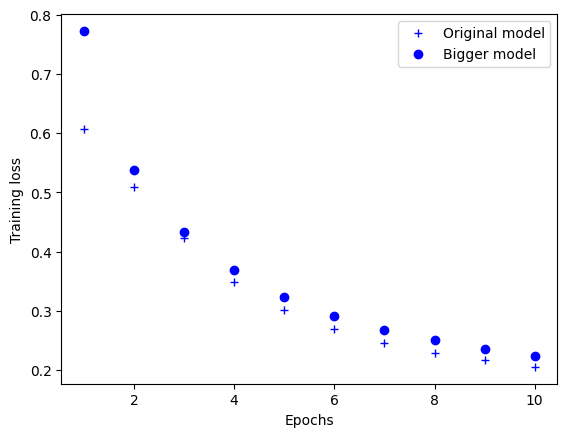

In [ ]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large
difference between the training and validation loss).

## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different
name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight
regularization to our movie review classification network:

In [ ]:
from keras import regularizers
l2_model = models.Sequential()
l2_model.add(mobilenet)
l2_model.add(GlobalAveragePooling2D())
l2_model.add(Flatten(input_shape=(224, 224, 3)))
l2_model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(224, 224, 3)))
l2_model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(Dense(2, activation='softmax'))

In [ ]:
l2_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['acc'])

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of
the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training
than at test time.

Here's the impact of our L2 regularization penalty:

In [ ]:
l2_model_hist = l2_model.fit(train_ds,
                             epochs=10,
                             validation_data=test_ds)

Epoch 1/10
56/56 [==============================] - 126s 2s/step - loss: 0.6755 - acc: 0.6542 - val_loss: 0.6118 - val_acc: 0.6990
Epoch 2/10
56/56 [==============================] - 93s 2s/step - loss: 0.5420 - acc: 0.7831 - val_loss: 0.5214 - val_acc: 0.7908
Epoch 3/10
56/56 [==============================] - 89s 2s/step - loss: 0.4632 - acc: 0.8260 - val_loss: 0.4536 - val_acc: 0.8418
Epoch 4/10
56/56 [==============================] - 90s 2s/step - loss: 0.4060 - acc: 0.8582 - val_loss: 0.3998 - val_acc: 0.8724
Epoch 5/10
56/56 [==============================] - 91s 2s/step - loss: 0.3661 - acc: 0.8734 - val_loss: 0.3626 - val_acc: 0.8878
Epoch 6/10
56/56 [==============================] - 90s 2s/step - loss: 0.3383 - acc: 0.8887 - val_loss: 0.3357 - val_acc: 0.8929
Epoch 7/10
56/56 [==============================] - 93s 2s/step - loss: 0.3178 - acc: 0.8983 - val_loss: 0.3161 - val_acc: 0.9031
Epoch 8/10
56/56 [==============================] - 88s 2s/step - loss: 0.3028 - acc: 0.9

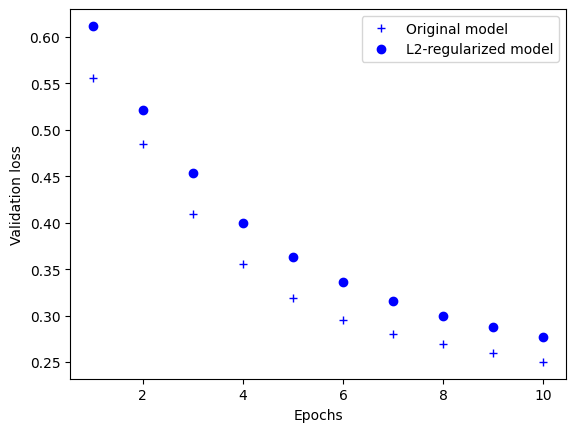

In [ ]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()



As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses),
even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [ ]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

## Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5,
1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to
balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, `layer_output`, of shape `(batch_size, features)`. At training time, we would be
zero-ing out at random a fraction of the values in the matrix:

In [ ]:
# At training time: we drop out 50% of the units in the output
layer_output *= np.randint(0, high=2, size=layer_output.shape)


At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the
units):

In [ ]:
# At test time:
layer_output *= 0.5

NameError: name 'layer_output' is not defined


Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is
often the way it is implemented in practice:

In [ ]:
# At training time:
layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Note that we are scaling *up* rather scaling *down* in this case
layer_output /= 0.5


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present.

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

In [ ]:
model.add(layers.Dropout(0.5))

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [ ]:
from keras.layers import Dropout
dpt_model = models.Sequential()
dpt_model.add(mobilenet)
dpt_model.add(GlobalAveragePooling2D())
dpt_model.add(Flatten(input_shape=(224, 224, 3)))
dpt_model.add(Dense(16, activation='relu', input_shape=(224, 224, 3)))
dpt_model.add(Dropout(0.5))
dpt_model.add(Dense(16, activation='relu'))
dpt_model.add(Dropout(0.5))
dpt_model.add(Dense(2, activation='softmax'))

dpt_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['acc'])

In [ ]:
dpt_model_hist = dpt_model.fit(train_ds,
                               epochs=10,
                               validation_data=test_ds)

Epoch 1/10
56/56 [==============================] - 96s 2s/step - loss: 0.9021 - acc: 0.5463 - val_loss: 0.5928 - val_acc: 0.7092
Epoch 2/10
56/56 [==============================] - 90s 2s/step - loss: 0.7391 - acc: 0.5667 - val_loss: 0.5799 - val_acc: 0.7398
Epoch 3/10
56/56 [==============================] - 93s 2s/step - loss: 0.6740 - acc: 0.5944 - val_loss: 0.5744 - val_acc: 0.7653
Epoch 4/10
56/56 [==============================] - 90s 2s/step - loss: 0.6365 - acc: 0.6181 - val_loss: 0.5271 - val_acc: 0.8367
Epoch 5/10
56/56 [==============================] - 90s 2s/step - loss: 0.6034 - acc: 0.6644 - val_loss: 0.4927 - val_acc: 0.8673
Epoch 6/10
56/56 [==============================] - 90s 2s/step - loss: 0.5988 - acc: 0.6661 - val_loss: 0.4810 - val_acc: 0.8827
Epoch 7/10
56/56 [==============================] - 91s 2s/step - loss: 0.5714 - acc: 0.6859 - val_loss: 0.4567 - val_acc: 0.8724
Epoch 8/10
56/56 [==============================] - 92s 2s/step - loss: 0.5530 - acc: 0.69

Let's plot the results:

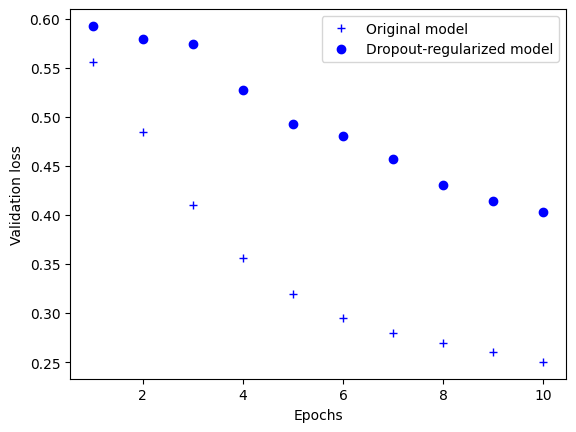

In [ ]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.

# GRID SEARCH

In [ ]:

!pip install scikeras

In [ ]:
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Activation
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [ ]:
seed = 7
tf.random.set_seed(seed)

mobilenet=MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

for layers in mobilenet.layers:
    layers.trainable=False


original_model = models.Sequential()
original_model.add(mobilenet)
original_model.add(GlobalAveragePooling2D())
original_model.add(Flatten(input_shape=(224,224,3)))
original_model.add(Dense(16, activation='relu',input_shape=(224,224,3)))
original_model.add(Dense(16, activation='relu'))
original_model.add(Dense(1, activation='softmax'))
original_model.compile(optimizer="adam",
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

data = datagen.flow_from_directory(
    path,
    target_size=(224, 224),  # Tamaño al que se redimensionarán las imágenes
    batch_size=32,
    class_mode='binary',  # Tipo de problema: 'binary' para clasificación binaria
    subset='training'  # Indica que es el conjunto de entrenamiento
)

X , Y = data.next()
print(X.shape)
print(Y.shape)

Found 1770 images belonging to 2 classes.
(32, 224, 224, 3)
(32,)


In [ ]:
# create model
model = KerasClassifier(model=original_model, loss="binary_crossentropy", epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]

param_grid = dict(optimizer=optimizer,batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))